<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Read-CTD-χpod-data-and-convert-to-netCDF" data-toc-modified-id="Read-CTD-χpod-data-and-convert-to-netCDF-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Read CTD χpod data and convert to netCDF</a></span></li><li><span><a href="#Read-transect-+-ancillary-datasets" data-toc-modified-id="Read-transect-+-ancillary-datasets-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Read transect + ancillary datasets</a></span><ul class="toc-item"><li><span><a href="#plots" data-toc-modified-id="plots-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>plots</a></span></li></ul></li><li><span><a href="#Calculate" data-toc-modified-id="Calculate-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Calculate</a></span></li><li><span><a href="#Calculate-2" data-toc-modified-id="Calculate-2-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Calculate 2</a></span></li></ul></div>

# Read CTD χpod data and convert to netCDF

In [94]:
filename = '/home/deepak/work/eddydiff/datasets/P06/P06-means.mat'

mat = sp.io.loadmat(filename, squeeze_me=True)

p06 = xr.Dataset()

dims = ['cast', 'pres']
coords = {'cast': np.arange(300)+1, 'pres': mat['P'].astype(np.float32)}

for varname in ['chi', 'eps', 'Jq', 'KT', 'N2', 'dTdz', 'TPvar', 't', 's']:
    p06[varname] = xr.DataArray(mat[varname].T, dims=dims, coords=coords)
    
for varname in ['lat', 'lon', 'dnum', 'dist']:
    p06[varname] = xr.DataArray(mat[varname], dims=['cast'], coords={'cast':coords['cast']})

p06 = p06.rename({'t': 'T', 's': 'S', 'dnum': 'time'})
p06['time'].values = dcpy.util.datenum2datetime(p06['time'].values)
p06['sigma_0'] = xr.DataArray(sw.pden(p06.S, p06['T'], p06['pres'], 0), dims=dims, coords=coords)
p06['rho'] = xr.DataArray(sw.dens(p06.S, p06['T'], p06['pres']), dims=dims, coords=coords)
p06 = p06.rename({'pres': 'P'})
# code expects P as pressure index vector; pres as actual 2D pressure
p06['pres'] = xr.broadcast(p06['cast'], p06['P'])[1]

p06 = p06.set_coords(['time', 'lon', 'lat', 'dist', 'pres'])

# reset co-ords to match ECCO/argo fields.
p06['lon'][p06.lon <= 0] += 360
p06 = p06.drop([1, 2], dim='cast')
p06 = p06.drop(np.arange(250, 301), dim='cast')

# fill in NaNs
p06['lon'] = p06.lon.interpolate_na(dim='cast')
p06['lat'] = p06.lat.interpolate_na(dim='cast')

# add in bathymetry
etopo = xr.open_dataset('/home/deepak/datasets/ETOPO2v2g_f4.nc4', autoclose=True).drop(180., 'x')
etopo = dcpy.oceans.dataset_center_pacific(etopo.rename({'x': 'lon', 'y': 'lat'}))
p06['bathy'] = etopo.interp(lon=p06.lon, lat=p06.lat).z

p06.attrs['name'] = 'P06 merged dataset'
p06.attrs['transect_name'] = 'P06'
p06.to_netcdf('/home/deepak/work/eddydiff/datasets/P06/p06.nc')
p06

<xarray.Dataset>
Dimensions:  (P: 601, cast: 247)
Coordinates:
  * cast     (cast) int64 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 ...
  * P        (P) float32 0.0 10.0 20.0 30.0 40.0 50.0 60.0 70.0 80.0 90.0 ...
    lat      (cast) float64 -30.08 -30.08 -30.08 -30.08 -30.08 -30.08 -30.08 ...
    lon      (cast) float64 153.6 153.7 153.7 153.8 153.9 154.0 154.0 154.2 ...
    time     (cast) datetime64[ns] 2017-07-04T15:05:44 2017-07-04T19:58:21 ...
    dist     (cast) float64 0.0 7.686 14.41 22.48 30.76 34.63 38.45 53.85 ...
    pres     (cast, P) float32 0.0 10.0 20.0 30.0 40.0 50.0 60.0 70.0 80.0 ...
Data variables:
    chi      (cast, P) float64 nan nan nan nan nan nan nan nan nan nan nan ...
    eps      (cast, P) float64 nan nan nan nan nan nan nan nan nan nan nan ...
    Jq       (cast, P) float64 nan nan nan nan nan nan nan nan nan nan nan ...
    KT       (cast, P) float64 nan nan nan nan nan nan nan nan nan nan nan ...
    N2       (cast, P) float64 nan nan nan nan nan

# Read transect + ancillary datasets

In [288]:
sys.path.append('../eddydiff/')
import eddydiff as ed

p06 = xr.open_dataset('/home/deepak/work/eddydiff/datasets/P06/p06.nc', autoclose=True)
bathy = p06.bathy.copy()
p06 = p06.where(p06['KT'] < 5e-3)
p06['bathy'] = bathy
p06['KtTz'] = p06.KT * p06.dTdz
p06

eccograd, argograd, cole = ed.read_all_datasets(kind='monthly', transect=p06)

/home/deepak/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
/home/deepak/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
/home/deepak/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
/home/deepak/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


/home/deepak/anaconda3/lib/python3.6/site-packages/_pytest/fixtures.py:847: DeprecationWarning: The `convert` argument is deprecated in favor of `converter`.  It will be removed after 2019/01.
  params = attr.ib(convert=attr.converters.optional(tuple))
/home/deepak/anaconda3/lib/python3.6/site-packages/_pytest/fixtures.py:849: DeprecationWarning: The `convert` argument is deprecated in favor of `converter`.  It will be removed after 2019/01.
  ids = attr.ib(default=None, convert=_ensure_immutable_ids)


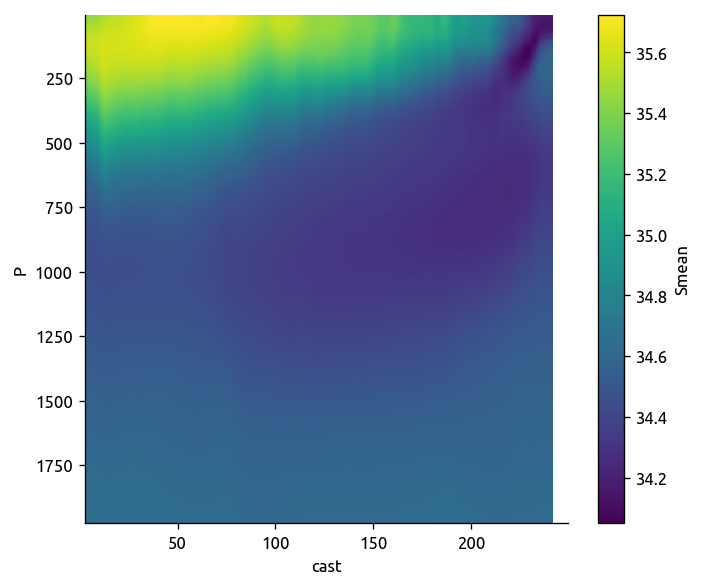

In [2]:
argograd.Smean.plot(x='cast', yincrease=False)

## plots

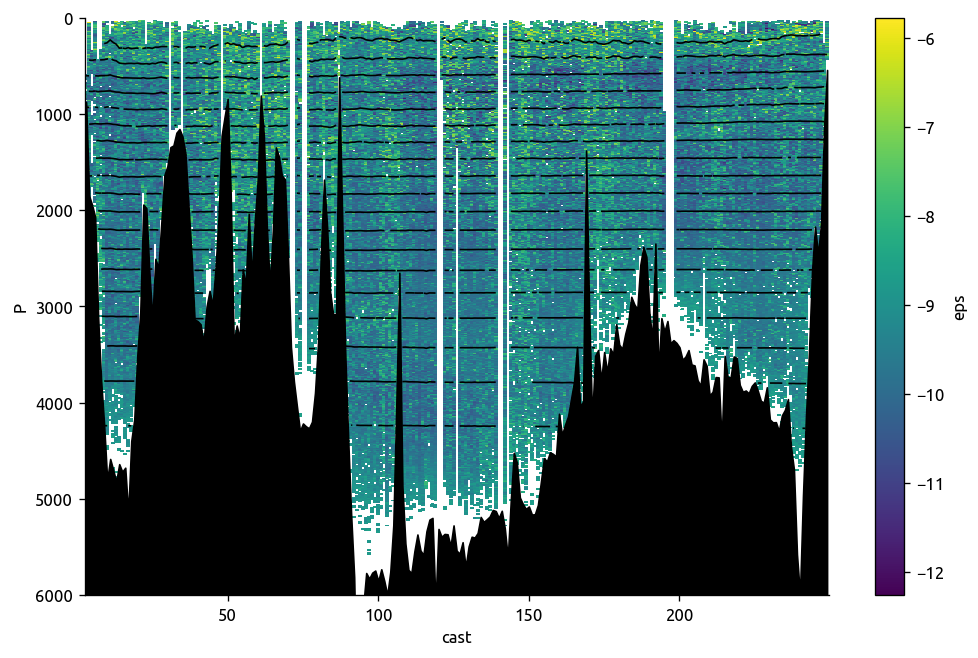

In [259]:
np.log10(p06.eps).plot(x='cast')
p06.rho.plot.contour(colors='k', x='cast', yincrease=False,
                     levels=pd.qcut(p06.rho.values.ravel(), 20, retbins=True)[1])
plt.gca().fill_between(p06.cast, 6100, -p06.bathy, color='k', zorder=10)
plt.gcf().set_size_inches(10, 10/1.6)

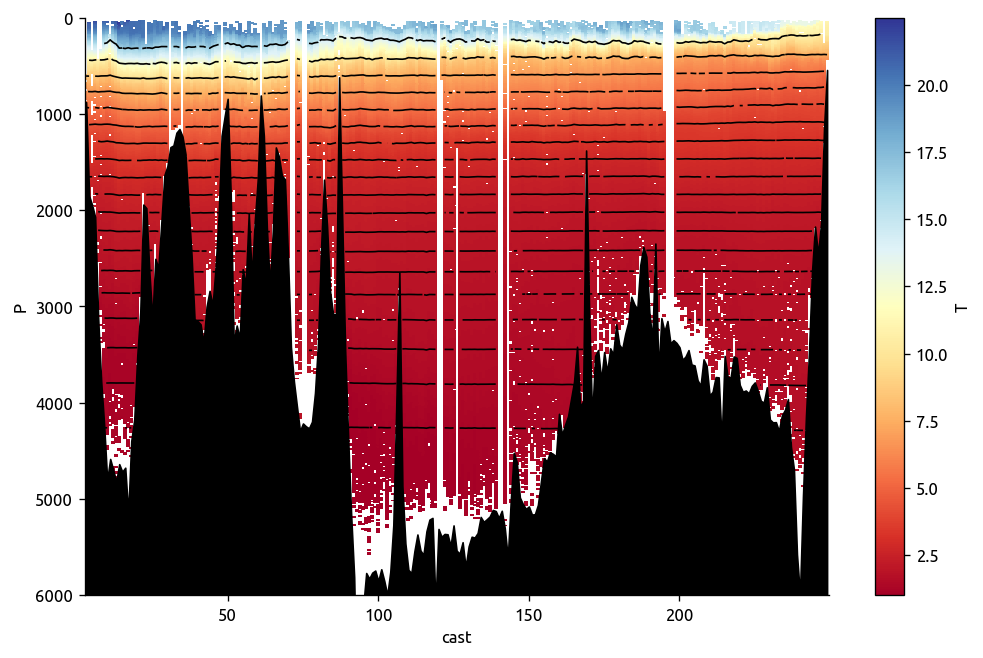

In [6]:
p06['T'].plot(x='cast', cmap=mpl.cm.RdYlBu)
p06.rho.plot.contour(colors='k', x='cast', yincrease=False,
                     levels=pd.qcut(p06.rho.values.ravel(), 20, retbins=True)[1])
plt.gca().fill_between(p06.cast, 6100, -p06.bathy, color='k', zorder=10)
plt.gcf().set_size_inches(10, 10/1.6)

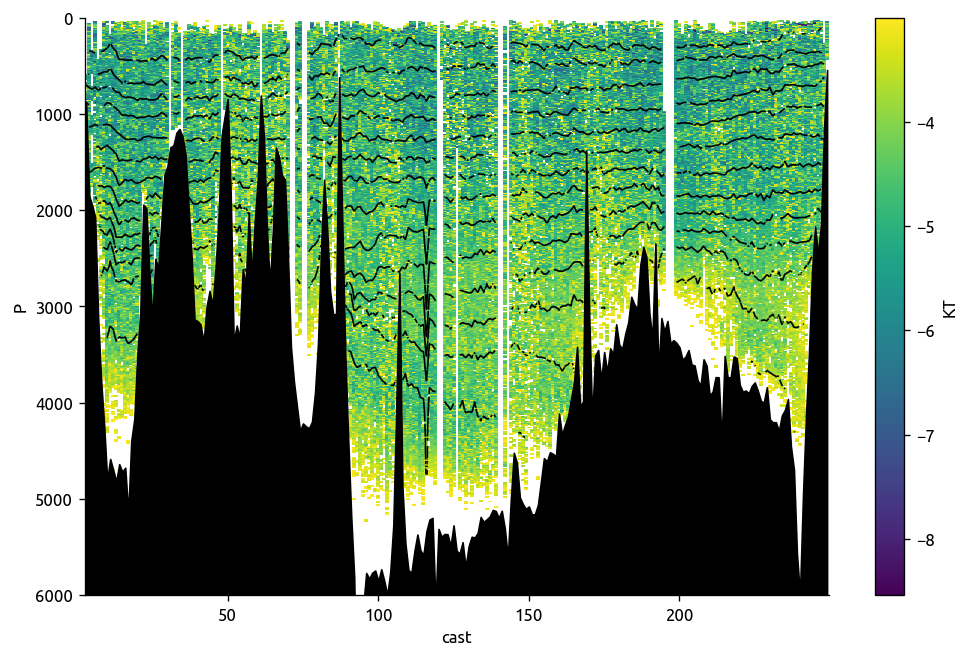

In [284]:
np.log10(p06['KT']).plot(x='cast')
p06.rho.plot.contour(colors='k', x='cast', yincrease=False, labels=True,
                     levels=pd.qcut(p06.rho.values.ravel(), 15, retbins=True)[1])
plt.gca().fill_between(p06.cast, 6100, -p06.bathy, color='k', zorder=10)
plt.gcf().set_size_inches(10, 10/1.6)

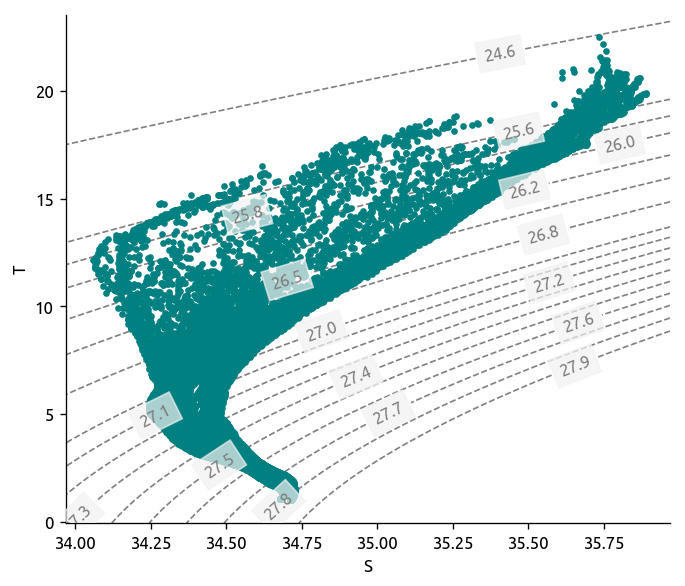

In [355]:
bins = [1024.6, 
        1025.6, 1025.8, 
        1026.0, 1026.25, 1026.5, 1026.75, 
        1027.0, 1027.1, 1027.2, 1027.3, 1027.4, 1027.5, 1027.6, 1027.7, 1027.8, 1027.9]
dcpy.oceans.TSplot(p06.S, p06['T'], p06.pres, rho_levels=bins)

(array([4.000e+00, 9.000e+00, 9.000e+00, 5.000e+01, 1.990e+02, 6.510e+02,
        1.814e+03, 3.899e+03, 6.411e+03, 8.074e+03, 8.303e+03, 7.910e+03,
        7.138e+03, 6.463e+03, 5.739e+03, 4.960e+03, 3.722e+03, 2.873e+03,
        2.389e+03, 1.704e+03, 1.149e+03, 7.670e+02, 5.890e+02, 4.620e+02,
        3.430e+02, 1.730e+02, 9.500e+01, 5.400e+01, 1.900e+01, 3.000e+00]),
 array([-3.27496821, -3.06254641, -2.85012461, -2.63770281, -2.42528101,
        -2.21285921, -2.00043741, -1.78801561, -1.57559381, -1.36317201,
        -1.15075021, -0.93832841, -0.72590661, -0.51348481, -0.30106301,
        -0.08864121,  0.12378059,  0.33620239,  0.54862419,  0.76104599,
         0.97346779,  1.18588959,  1.39831139,  1.61073319,  1.82315499,
         2.03557679,  2.24799859,  2.46042039,  2.67284219,  2.88526399,
         3.09768579]),
 <a list of 30 Patch objects>)

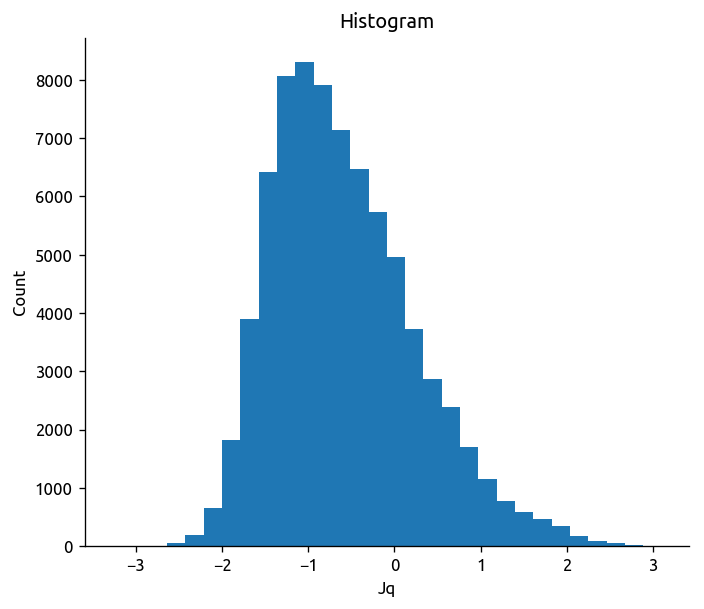

In [61]:
np.log10(p06.Jq).plot.hist(bins=30)

# Calculate

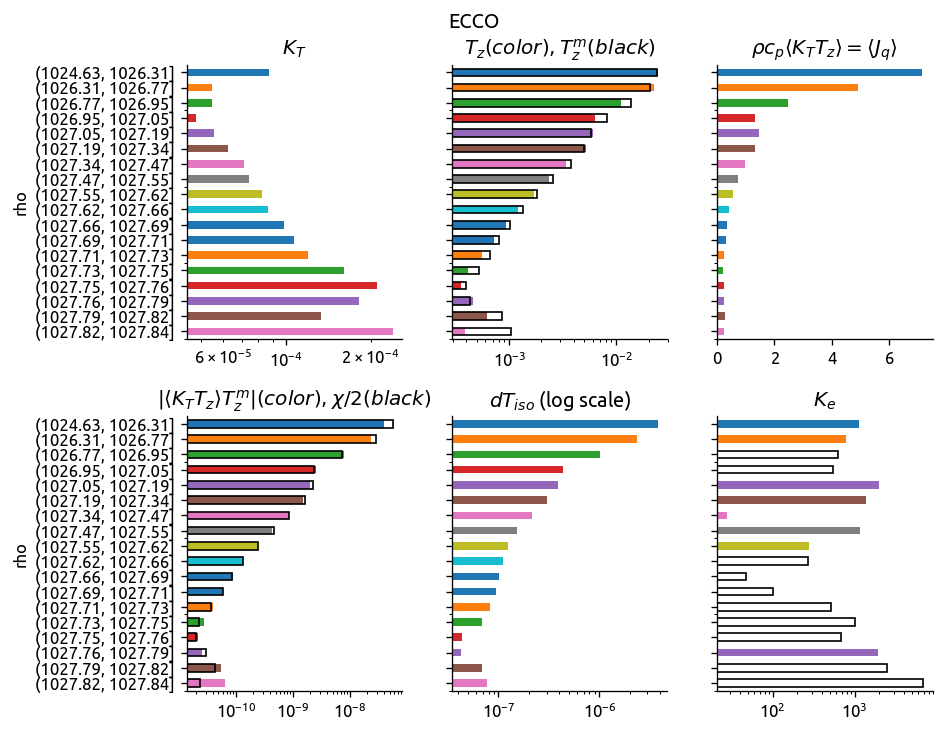

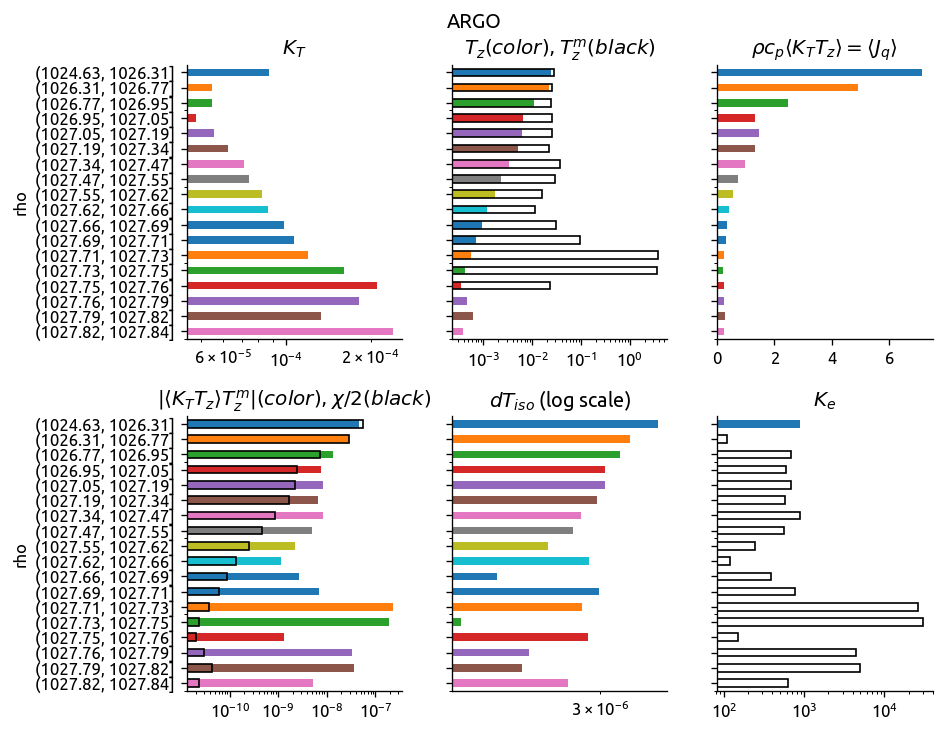

In [283]:
nbins = 18

p06['rho'] = p06['sigma_0']
eccograd['ρmean'] = eccograd['sigma_0']


eccoKe = ed.process_transect_1d(p06, eccograd, 'ECCO', nbins=nbins)
ed.plot_bar_Ke(eccoKe, Ke_log=True)

argoKe = ed.process_transect_1d(p06, argograd, 'ARGO', nbins=nbins)
ed.plot_bar_Ke(argoKe, Ke_log=True)

# Calculate 2

/home/deepak/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
/home/deepak/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
/home/deepak/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
/home/deepak/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


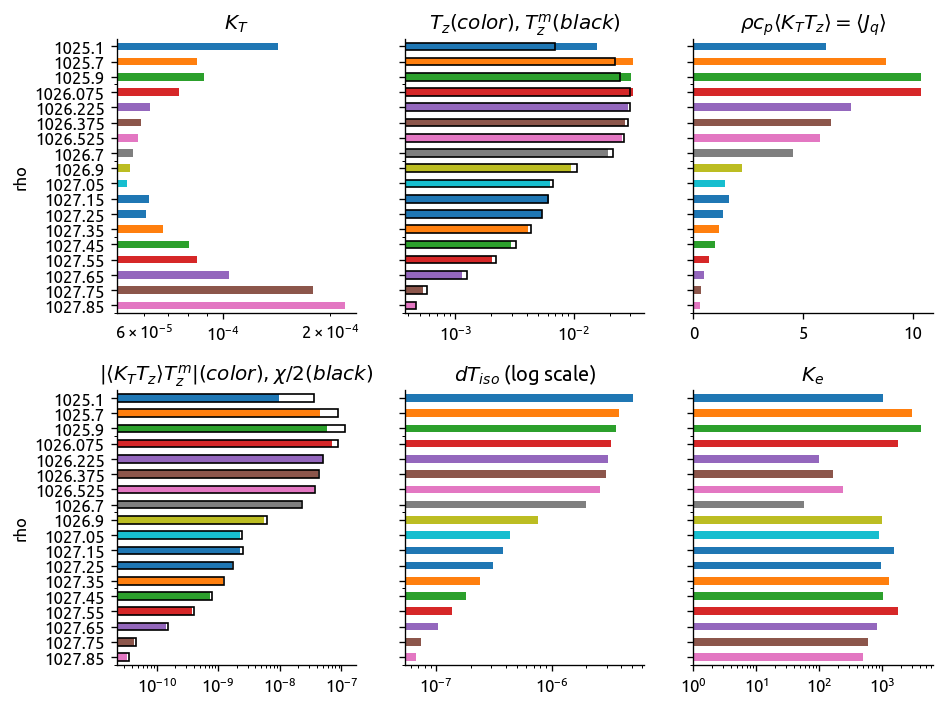

In [383]:
sys.path.append('../eddydiff/')
import eddydiff as ed

p06 = xr.open_dataset(
    '/home/deepak/work/eddydiff/datasets/P06/p06.nc', autoclose=True)
bathy = p06.bathy.copy()
p06 = p06.where(p06['KT'] < 1e-3)
p06['bathy'] = bathy
p06['KtTz'] = p06.KT * p06.dTdz
p06

if 'eccograd' not in locals():
    eccograd, argograd, cole = ed.read_all_datasets(
        kind='monthly', transect=p06)

# use sigma_0
p06['rho'] = p06['sigma_0']
eccograd['ρmean'] = eccograd['sigma_0']

bins = [1024.6,
        1025.6, 1025.8,
        1026.0, 1026.15, 1026.3, 1026.45, 1026.6, 1026.8, 
        1027.0, 1027.1, 1027.2, 1027.3, 1027.4, 1027.5, 1027.6, 1027.7, 1027.8, 1027.9]
trdens, bins = ed.bin_to_density_space(p06, bins=bins)

eccograd['dist'] = p06.dist
eccodens, _ = ed.bin_to_density_space(eccograd.rename({'ρmean': 'rho'}), bins)

newKe = xr.Dataset()
newKe['KT'] = trdens.KT.mean(dim='cast')
newKe['chi'] = trdens.chi.mean(dim='cast')
newKe['KtTz'] = trdens.KtTz.mean(dim='cast')
newKe['dTiso'] = np.abs(eccodens.dTiso.mean(dim='cast'))
newKe['dTmdz'] = np.abs(eccodens.dTdz.mean(dim='cast'))
newKe['dTdz'] = trdens.dTdz.mean(dim='cast')

newKe['Ke'] = ((newKe['chi']/2 - np.abs(newKe['KtTz'] * newKe['dTmdz']))
               / (newKe['dTiso']**2))

ed.plot_bar_Ke(newKe.to_dataframe())

The above really awesome plot results after a few tweaks.

1. Doing things in σ_0.

2. Handcrafted density bins using the T-S diagram as guide.
   This is really important. Had to fiddle around slightly to not get negative
   values. Biggest improvement is that I can now resolve thermocline and coarsen
   the abyss. This is necessary because the big signal is in the thermocline and
   the abyssal values need to account for topography. Automatically choosing
   bins by pandas.cut/pandas.qcut would put too many bins down deep and fewer in
   the thermocline.

3. Throwing out all KT > 1e-3. This is really important. Will need to QC the
   values coming out of the CTD_chipod analysis code.

4. Redid (vectorized) the bin-averaging by cast. This is a better way to do it I
   think. Have to use pandas so I can groupby using multiple variables.

5. I tried fitting straight lines to the bin-averaged ECCO field to get dTiso
   but this seems to under-estimate values. Currently I bin-average dTiso and
   use that. This might not be crazy because it mirrors what I do with χ and we
   know that χ has to go along with the appropriate local gradients. i.e. if
   high χ coincides with high dTiso locally, we want the averaged dTiso to be
   biased high since averaged χ will be biased high.

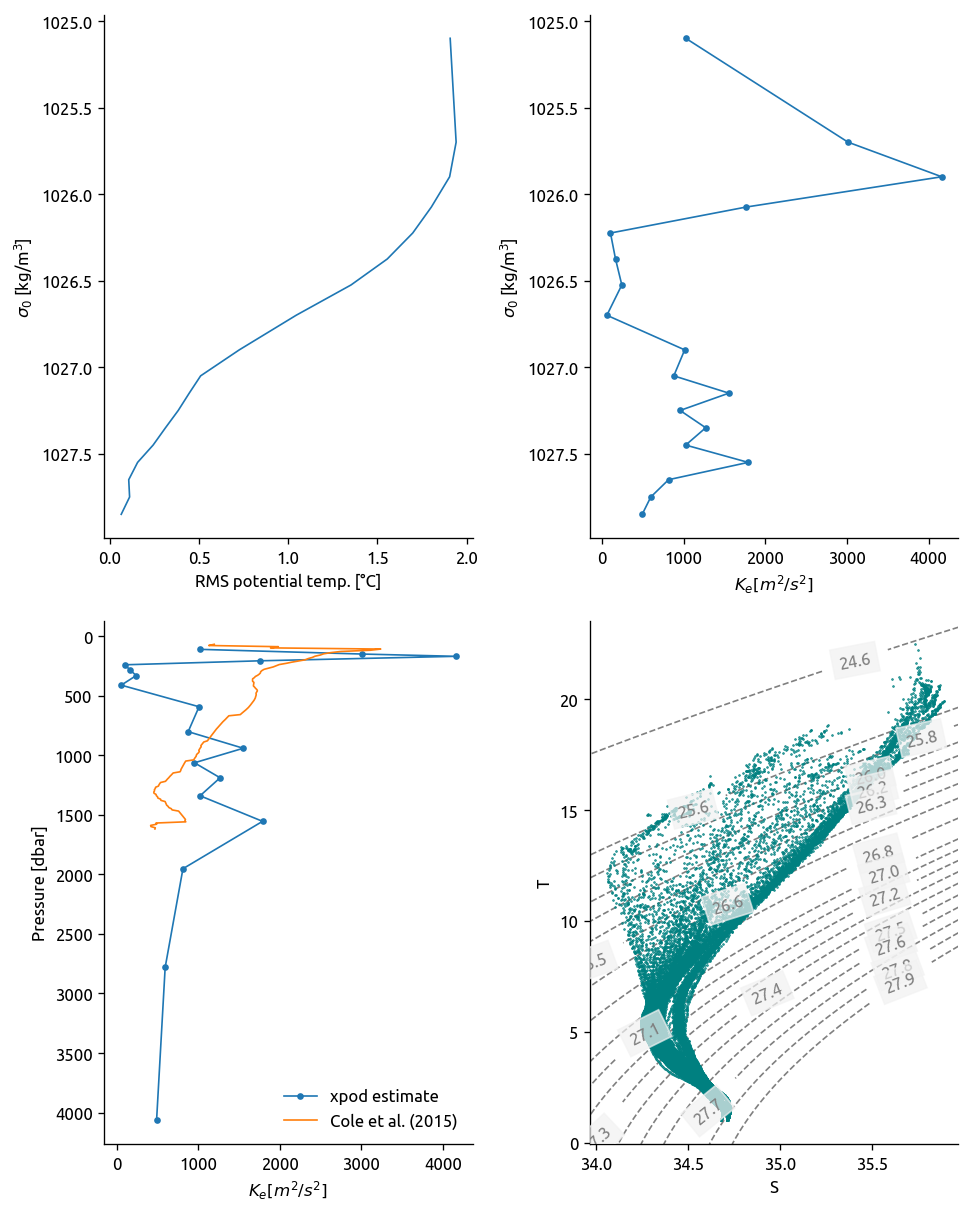

In [393]:
f, ax = plt.subplots(2, 2, constrained_layout=True)

Trms = trdens['T'].std(dim='cast')
Trms.name = 'RMS potential temp.'
Trms.attrs['units'] = '°C'
Trms.plot(ax=ax[0, 0], y='rho', yincrease=False)
newKe.Ke.where(newKe.Ke > 0).plot(
    marker='.', ax=ax[0, 1], y='rho', yincrease=False)
ax[0, 0].set_ylabel('$σ_0$ [kg/m$^3$]')
ax[0, 1].set_ylabel('$σ_0$ [kg/m$^3$]')
ax[0, 1].set_xlabel('$K_e [m^2/s^2]$ ')

ax[1, 0].plot(newKe.Ke.where(newKe.Ke > 0), trdens.P.mean(dim='cast'), '.-')
ax[1, 0].plot(cole.diffusivity.mean(dim='cast'), cole.P)
ax[1, 0].legend(['χpod estimate', 'Cole et al. (2015)'])
ax[1, 0].invert_yaxis()
ax[1, 0].set_ylabel('Pressure [dbar]')
ax[1, 0].set_xlabel('$K_e [m^2/s^2]$ ')

dcpy.oceans.TSplot(p06.S, p06['T'], p06.pres,
                   rho_levels=bins, ax=ax[1, 1], ms=1)

f.set_size_inches(8, 10)

Linear fits to ECCO T along ρ surfaces in the along-transect direction doesn't work. The field has too much curvature

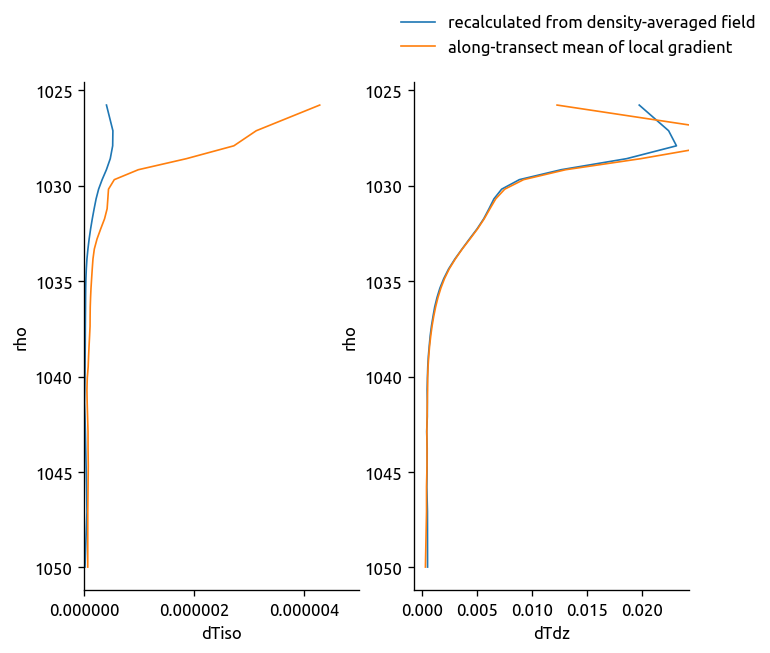

In [300]:
# recalculate gradients from mean fields in density space
dTiso = xr.ones_like(eccodens.rho) * np.nan
dTiso.name = 'dTiso'
dTdz = xr.ones_like(eccodens.rho) * np.nan
dTdz.name = 'dTdz'

for idx, rr in enumerate(eccodens.rho):
    Tvec = eccodens.Tmean.sel(rho=rr)
    mask = np.isnan(Tvec)
    if len(Tvec[~mask]) > 0:
        slope, intercept, r_value, p_value, std_err = sp.stats.linregress(eccodens.dist[~mask]*1000,
                                                                          Tvec[~mask])
    dTiso[idx] = slope

dTdz.values = -np.gradient(eccodens.Tmean.mean(dim='cast'),
                           eccodens.P.mean(dim='cast'))

f, ax = plt.subplots(1, 2)
np.abs(dTiso).plot.line(ax=ax[0], y='rho')
np.abs(eccodens.dTiso).mean(dim='cast').plot.line(
    ax=ax[0], y='rho', yincrease=False)
ax[0].set_xlim([0, 5e-6])
f.legend(['recalculated from density-averaged field',
          'along-transect mean of local gradient'])

dTdz.plot(ax=ax[1], y='rho', yincrease=False)
eccodens.dTdz.mean(dim='cast').plot.line(ax=ax[1], y='rho', yincrease=False)

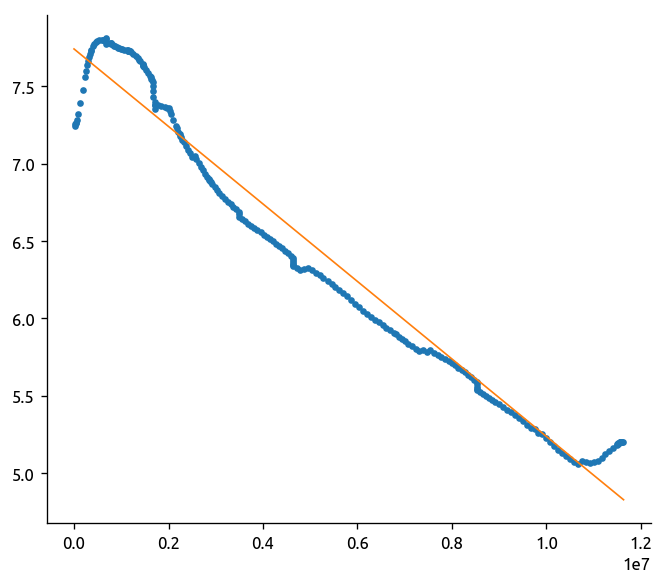

In [290]:
nn = 6

Tvec = eccodens.Tmean.isel(rho=nn)
mask = np.isnan(Tvec)
plt.plot(eccodens.dist[~mask]*1000, Tvec[~mask], '.')

plt.plot(eccodens.dist*1000, Tvec.mean() + dTiso.isel(rho=nn) *  (eccodens.dist-eccodens.dist.mean()) * 1000)

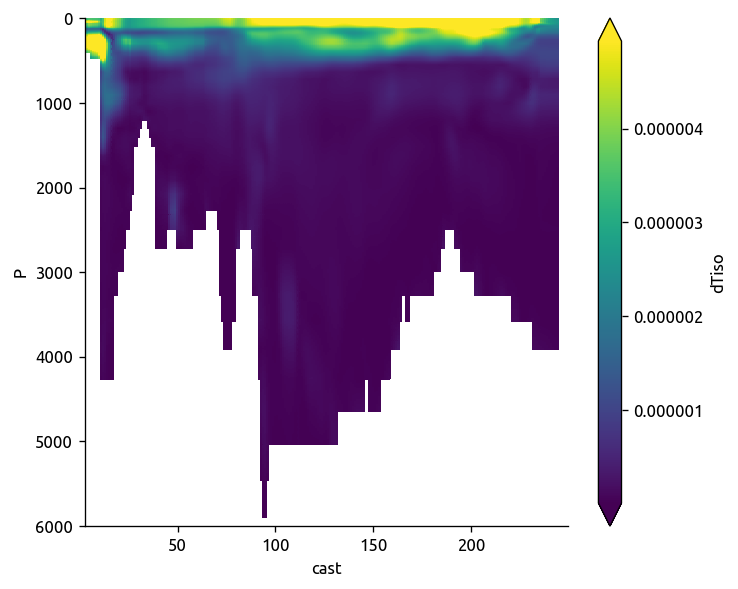

In [56]:
eccograd.dTiso.plot(x='cast', yincrease=False, robust=True)

In [22]:
clim = eccograd.copy()

clim = clim.to_dataframe().reset_index()

trmean, ρbins = ed.average_transect_1d(p06, nbins=15)
    
climrho = clim.groupby(pd.cut(clim.ρmean, ρbins, precision=1))

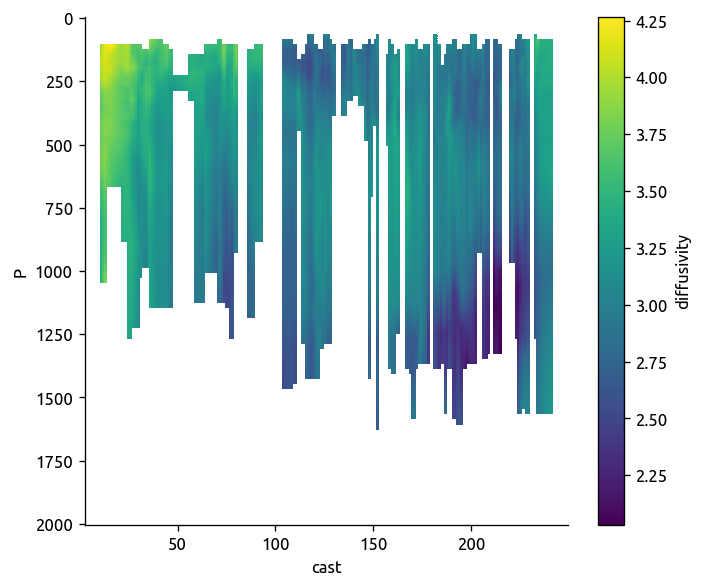

In [57]:
np.log10(cole.diffusivity).plot(x='cast', yincrease=False)

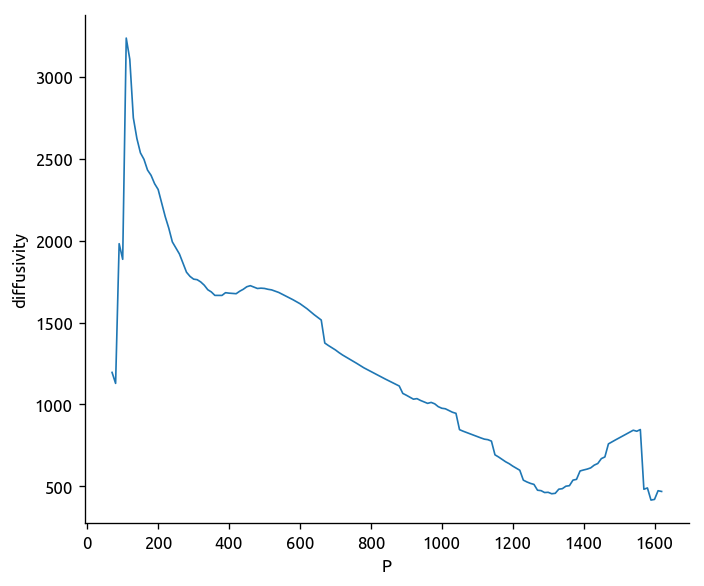

In [60]:
cole.diffusivity.mean(dim='cast').plot()

In [40]:
clim = eccograd.sel(time=9)
transect = p06.sel(P=slice(0, 2000))

trmean, ρbins = ed.average_transect_1d(transect, nbins=20)
gradmean = ed.average_clim(clim, transect, ρbins)

Ke = ed.estimate_Ke(trmean, gradmean)
Ke

,chi,KtTz,dTdz,dTmdz,dTiso,KT,Ke
rho,,,,,,,
"(1024.8000000000002, 1026.7]",1.340903e-07,1.843108e-06,0.021105,0.021170,4.694987e-06,0.000118,1271.439129
"(1026.7, 1027.5]",8.350073e-08,1.431120e-06,0.026548,0.023706,3.095114e-06,0.000058,816.732447
"(1027.5, 1028.2]",6.809042e-08,1.229691e-06,0.024866,0.026552,2.792055e-06,0.000053,178.802085
"(1028.2, 1028.9]",3.888472e-08,9.499299e-07,0.018603,0.019622,1.978210e-06,0.000053,205.196687
"(1028.9, 1029.4]",1.696346e-08,6.028373e-07,0.011949,0.011681,1.093078e-06,0.000053,1205.030222
"(1029.4, 1029.9]",1.025537e-08,4.112075e-07,0.008578,0.009867,4.934073e-07,0.000047,4396.180518
"(1029.9, 1030.4]",6.098227e-09,3.541930e-07,0.006906,0.006893,3.572366e-07,0.000053,4761.760099
"(1030.4, 1030.9]",5.922741e-09,3.396340e-07,0.006503,0.005814,3.952476e-07,0.000051,6315.357062
"(1030.9, 1031.4]",4.479737e-09,3.283833e-07,0.006106,0.005641,3.961862e-07,0.000056,2468.021433


In [19]:
def compare_transect_clim(transect, clim):

    f, ax = plt.subplots(3, 1, sharex=True, sharey=True)

    for aa, (trvar, climvar) in enumerate(zip(['T', 'S', 'rho'],
                                              ['Tmean', 'Smean', 'ρmean'])):
        _, levels = pd.qcut(transect[trvar].values.ravel(), 20, retbins=True)

        (clim[climvar]
         .sel(**ed.get_region_from_transect(p06)).isel(lat=1)
         .plot.contour(ax=ax[aa], levels=levels, x='lon', add_colorbar=True,
                       yincrease=False, cmap=mpl.cm.RdYlBu))
        (transect[trvar]
         .plot.contour(ax=ax[aa], levels=levels, colors='k',
                       x='lon', y='P', yincrease=False))

    trname = (transect.attrs['transect_name']
              if 'transect_name' in transect.attrs else 'transect')
    f.suptitle('Compare ' + trname + ' vs ' + clim.dataset, y=0.9)
    plt.gcf().set_size_inches((10, 12))


compare_transect_clim(p06, eccograd.sel(time=8))
plt.gca().set_ylim((2400, 0))
#  compare_transect_clim(p06, argograd)
# plt.gca().set_ylim((2400, 0))

ValueError: dimensions or multi-index levels ['time'] do not exist